# Branch and Bound Algorithm

This is my implementation of Branch and Bound algorithm for solving Mixed Integer Linear Programs. I used the linprog from scipy.optimize for the simplex method and I implemented a tree-based enumeration of feasible solutions.

I implemented the Branch and Bound algorithm as a class called BranchAndBound. The important functions in this class are the run() function which will find the optimum value and solution, and the visualize_tree() function which visualizes the tree.

Key steps of the algorithm are as follows:

1. LP Relaxation.
2. Branching. If solution contains non-integer values, we create two subproblems: one where the variable is constrained to be ≤ floor(value) and another where it is constrained to be ≥ ceil(value). this will be our branches.
3. Bounding. Use LP solution objective value as an upper bound and prune branches where the solution is infeasible or the upper bound is worse than the current best.
4. Visualization. Enumeration tree visualizes the branching process and the optimal solution is highlighted to clearly distinguish from the rest of the nodes. Enumeration tree sizes nodes, edges, and labels dynamically as tree becomes larger.

Sidenote: The root node is currently duplicated in the enumeration tree visualization due to how the branching logic initializes the tree. This does not affect the correctness of the algorithm or the solution, and all other nodes and branches function as expected.

In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import networkx as nx

'''
Implementation of Branch and Bound algorithm for integer programming.
Will solve the problem and also create a visualization for enumeration tree.
Uses linprog from scipy.optimize for simplex method.
'''

class BranchAndBound:
    def __init__(self, A, b, c, integer_indices):
        self.A = A
        self.b = b
        self.c = c
        self.integer_indices = integer_indices
        self.best_solution = None
        self.best_value = -np.inf
        self.tree = nx.DiGraph()  # Tree will be directed graph
        self.node_id = 0  # Unique node ID counter

    def solve_lp(self, A, b, c):
        res = linprog(-c, A_ub=A, b_ub=b, method="highs")  # Maximize -> Minimize by negating c
        if res.success:
            return res.fun, res.x
        return None, None

    def is_integer(self, x):
        return all(abs(x[i] - round(x[i])) < 1e-5 for i in self.integer_indices)

    def branch(self, node):
        A, b, c, x, z = node
        for i in self.integer_indices:
            if abs(x[i] - round(x[i])) > 1e-5:  # Check for non-integer values
                # Create left and right branches
                left_A = np.vstack([A, np.eye(1, len(x), i)])
                left_b = np.append(b, np.floor(x[i]))

                right_A = np.vstack([A, -np.eye(1, len(x), i)])
                right_b = np.append(b, -np.ceil(x[i]))

                return [
                    (left_A, left_b, c, None, None, f"x{i+1} ≤ {np.floor(x[i])}"),
                    (right_A, right_b, c, None, None, f"x{i+1} ≥ {np.ceil(x[i])}")
                ]
        return None  # No branching needed

    def add_tree_node(self, parent_id, label, is_final=False, edge_label=None):
        self.node_id += 1
        self.tree.add_node(self.node_id, label=label, is_final=is_final)
        if parent_id is not None:
            self.tree.add_edge(parent_id, self.node_id, label=edge_label)  # Add edge label dynamically
        return self.node_id

    def run(self):
        # Root node: LP relaxation
        z, x = self.solve_lp(self.A, self.b, self.c)
        if x is None:
            return None, "Infeasible problem"

        root_id = self.add_tree_node(None, f"z = {-z:.2f}\nx = {x.round(2)}")
        queue = [(root_id, self.A, self.b, self.c, x, -z, None)]  # Add None for the root's edge label

        while queue:
            parent_id, A, b, c, x, z, edge_label = queue.pop(0)

            # Solve LP at node
            z, x = self.solve_lp(A, b, c)
            if x is None or -z < self.best_value:  # Prune branch
                self.add_tree_node(parent_id, "Infeasible/Pruned", edge_label=edge_label)
                continue

            is_current_best = False
            if self.is_integer(x):  # Found integer solution
                if -z > self.best_value:
                    self.best_value = -z
                    self.best_solution = x
                    is_current_best = True
                node_id = self.add_tree_node(parent_id, f"z = {-z:.2f}\nx = {x.round(2)}", is_final=is_current_best, edge_label=edge_label)
            else:  # Branch further
                node_id = self.add_tree_node(parent_id, f"z = {-z:.2f}\nx = {x.round(2)}", edge_label=edge_label)
                branches = self.branch((A, b, c, x, -z))
                if branches:
                    for branch in branches:
                        queue.append((node_id, *branch))

        # Return the best solution or indicate infeasibility/unboundedness
        if self.best_solution is not None:
            return self.best_solution, self.best_value
        else:
            return None, "No optimal solution found"



    def visualize_tree(self):
        pos = self._manual_hierarchical_layout()

        node_labels = nx.get_node_attributes(self.tree, 'label')
        final_nodes = [n for n, d in self.tree.nodes(data=True) if d.get("is_final", False)]

        # Dynamic node sizing
        total_nodes = len(self.tree.nodes)
        max_size = 3000  # Max node size
        min_size = 300   # Min node size
        node_size = max(min_size, max_size // (total_nodes ** 0.5))  # Scale node size inversely with tree size

        # Adjust font size based on node size
        base_font_size = 12
        font_size = max(6, base_font_size * node_size / max_size)

        # Draw all nodes with dynamic size
        nx.draw(
            self.tree,
            pos,
            with_labels=False,
            node_size=node_size,
            node_color="lightblue",
        )
        nx.draw_networkx_labels(self.tree, pos, labels=node_labels, font_size=font_size, font_color="black")

        # Highlight the single best node
        if self.best_solution is not None:
            best_node = [
                n
                for n, d in self.tree.nodes(data=True)
                if d.get("label") == f"z = {self.best_value:.2f}\nx = {self.best_solution.round(2)}"
            ]
            nx.draw_networkx_nodes(
                self.tree, pos, nodelist=best_node, node_color="red", node_size=node_size
            )

        # Draw edges
        nx.draw_networkx_edges(self.tree, pos, arrowstyle="-|>", arrowsize=10)

        # Adjust edge label font size
        edge_labels = nx.get_edge_attributes(self.tree, 'label')  # Extract edge labels
        edge_font_size = max(6, font_size * 0.8)  # Slightly smaller font size for edge labels
        nx.draw_networkx_edge_labels(
            self.tree,
            pos,
            edge_labels=edge_labels,
            font_size=edge_font_size,  # Dynamically adjust edge label font size
            bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="none"),
            label_pos=0.5,
            rotate=False,
        )

        # Display the tree
        plt.title("Branch-and-Bound Tree Visualization")
        plt.show()


    def _manual_hierarchical_layout(self):
        """
        Nodes at the same depth (level) are horizontally aligned.
        Subtrees are centered under their parent nodes.
        """
        pos = {}
        subtree_widths = {}

        # Calculate subtree widths for centering
        def calculate_subtree_width(node):
            children = list(self.tree.successors(node))
            if not children:
                return 1  # Leaf node has a width of 1
            width = sum(calculate_subtree_width(child) for child in children)
            subtree_widths[node] = width
            return width

        # if no nodes on tree
        if len(self.tree.nodes) == 0:
            raise ValueError("The tree has no nodes. Ensure the tree is built correctly.")

        root_candidates = [n for n in self.tree.nodes if self.tree.in_degree(n) == 0]
        if not root_candidates:
            raise ValueError("No root node found in the tree. Ensure that the tree has a valid structure.")

        root = root_candidates[0]  # Take the first root candidate as the root
        calculate_subtree_width(root)

        # Assign positions recursively
        def assign_positions(node, x, y, x_spacing):
            children = list(self.tree.successors(node))
            if not children:
                pos[node] = (x, y)
                return x + x_spacing

            start_x = x
            for child in children:
                x = assign_positions(child, x, y - 1, x_spacing)
            pos[node] = ((start_x + x - x_spacing) / 2, y)  # Center parent over children
            return x

        assign_positions(root, 0, 0, 2)  # Initial x, y, and spacing between nodes
        return pos

# Example Cases

## 2 decision variables

Optimal Solution: [ 2. -0.]
Optimal Value: 6.0


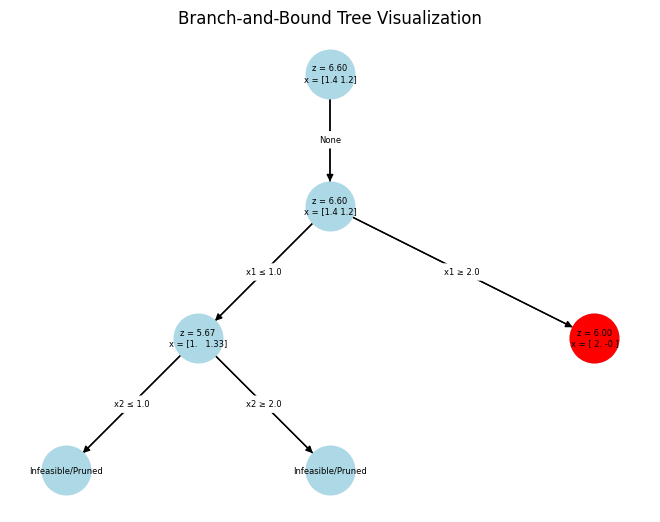

In [2]:
# Example usage:

'''
Suppose we had the problem
max    3x+2y
s.t.  2x+y≤4
      x+3y≤5
     x≥0,y≥0
       x,y∈ℤ
'''

# Input: Matrix A, vector b, vector c, list of integer indices
A = np.array([[2, 1],
              [1, 3]])
b = np.array([4, 5])
c = np.array([3, 2])
integer_indices = [0, 1]  # x and y are integer variables

# code to run the algorithm
solver = BranchAndBound(A, b, c, integer_indices)
solution, value = solver.run()

if solution is None: # If Infeasible/Unbounded
    print("No optimal solution found.")
else:
    print("Optimal Solution:", solution)
    print("Optimal Value:", value)
    solver.visualize_tree()


## 3 decision variables

Optimal Solution: [ 5. -0.  0.]
Optimal Value: 25.0


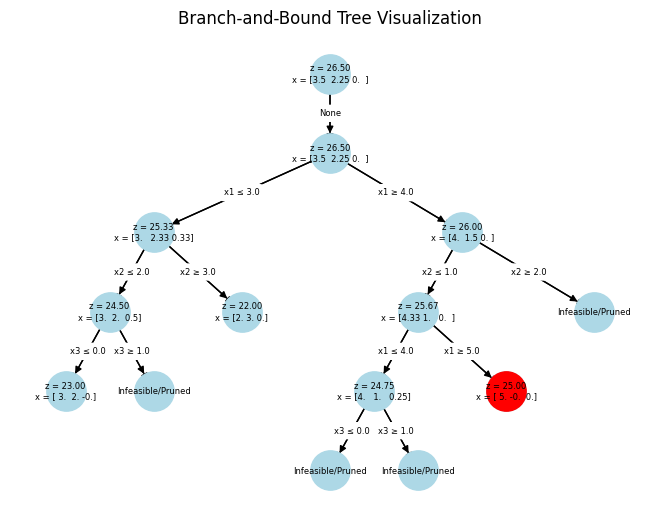

In [3]:
# max    5x+4y+3z
# s.t.   x+2y+z≤8
#     3x+2y+4z≤15
#     2x+3y+2z≤18
#     x≥0,y≥0,z≥0
#         x,y,z∈ℤ

A = np.array([
    [1, 2, 1],
    [3, 2, 4],
    [2, 3, 2]
])
b = np.array([8, 15, 18])
c = np.array([5, 4, 3])
integer_indices = [0, 1, 2]

solver = BranchAndBound(A, b, c, integer_indices)
solution, value = solver.run()

if solution is None: # If Infeasible/Unbounded
    print("No optimal solution found.")
else:
    print("Optimal Solution:", solution)
    print("Optimal Value:", value)
    solver.visualize_tree()


Optimal Solution: [4.  1.5 0. ]
Optimal Value: 26.0


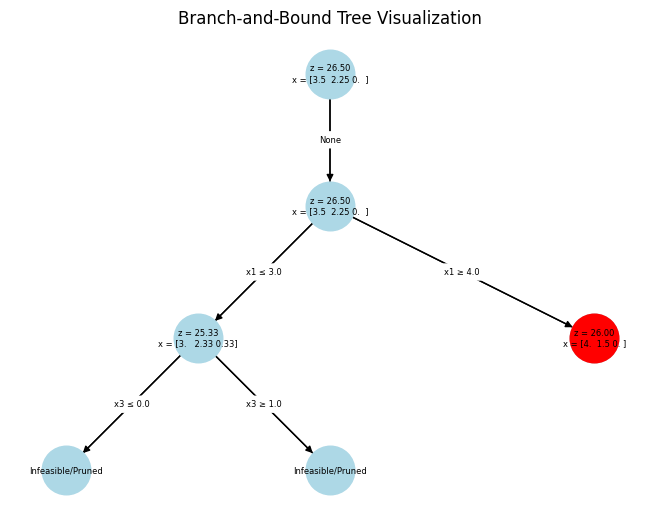

In [4]:
# What if only x and z are integers

# max    5x+4y+3z
# s.t.   x+2y+z≤8
#     3x+2y+4z≤15
#     2x+3y+2z≤18
#     x≥0,y≥0,z≥0
#           x,z∈ℤ

A = np.array([
    [1, 2, 1],
    [3, 2, 4],
    [2, 3, 2]
])
b = np.array([8, 15, 18])
c = np.array([5, 4, 3])
integer_indices = [0, 2] # x and z variable

solver = BranchAndBound(A, b, c, integer_indices)
solution, value = solver.run()

if solution is None: # If Infeasible/Unbounded
    print("No optimal solution found.")
else:
    print("Optimal Solution:", solution)
    print("Optimal Value:", value)
    solver.visualize_tree()

Optimal Solution: [3.66666667 2.         0.        ]
Optimal Value: 26.333333333333332


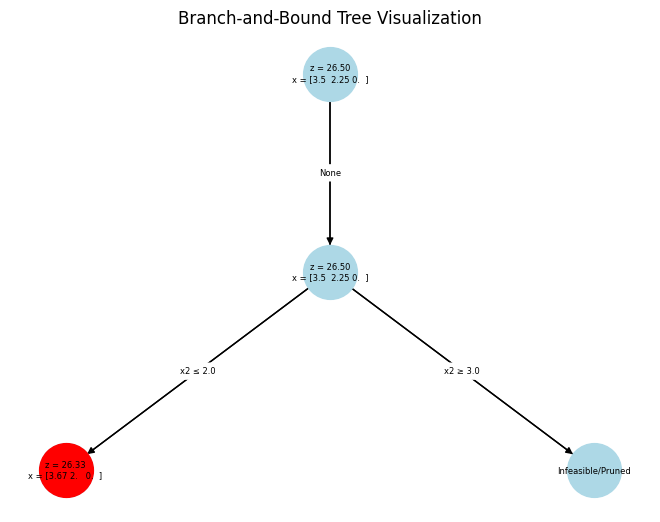

In [5]:
# What if only y and z are integers

# max    5x+4y+3z
# s.t.   x+2y+z≤8
#     3x+2y+4z≤15
#     2x+3y+2z≤18
#     x≥0,y≥0,z≥0
#           y,z∈ℤ

A = np.array([
    [1, 2, 1],
    [3, 2, 4],
    [2, 3, 2]
])
b = np.array([8, 15, 18])
c = np.array([5, 4, 3])
integer_indices = [1, 2]

solver = BranchAndBound(A, b, c, integer_indices)
solution, value = solver.run()

if solution is None: # If Infeasible/Unbounded
    print("No optimal solution found.")
else:
    print("Optimal Solution:", solution)
    print("Optimal Value:", value)
    solver.visualize_tree()

## 4 decision variables

Optimal Solution: [6. 1. 0. 2.]
Optimal Value: 58.0


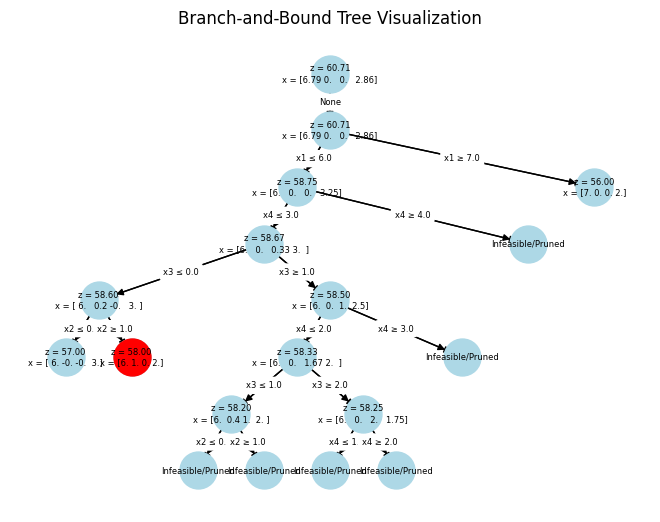

In [6]:
A = np.array([
    [4, 3, 2, 1],
    [2, 5, 3, 4],
    [3, 2, 5, 2]
])
b = np.array([30, 25, 35])
c = np.array([6, 8, 5, 7])
integer_indices = [0, 1, 2, 3]  # All variables are integer

solver = BranchAndBound(A, b, c, integer_indices)
solution, value = solver.run()

if solution is None: # If Infeasible/Unbounded
    print("No optimal solution found.")
else:
    print("Optimal Solution:", solution)
    print("Optimal Value:", value)
    solver.visualize_tree()


## Unbounded Problem

In [7]:
# Unbounded problem:
# max      x+y
# s.t.   x+y≥5
#        x+y≥3
#      x≥0,y≥0
#        x,y∈ℤ

A = np.array([[-1, -1],
              [-1, -1]])  # Note: Ax ≥ b -> -Ax ≤ -b
b = np.array([-5, -3])
c = np.array([1, 1]) # Maximize z = x + y
integer_indices = [0, 1]

solver = BranchAndBound(A, b, c, integer_indices)
solution, value = solver.run()

if solution is None: # If Infeasible/Unbounded
    print("No optimal solution found.")
else:
    print("Optimal Solution:", solution)
    print("Optimal Value:", value)
    solver.visualize_tree()


No optimal solution found.


## Infeasible Problem

In [8]:
# Infeasible problem:
# max      x+y
# s.t.   x+y≤1
#        x+y≥3
#      x≥0,y≥0
#        x,y∈ℤ

A = np.array([[1, 1],
              [-1, -1]])  # Note: Ax ≥ b -> -Ax ≤ -b
b = np.array([1, -3])
c = np.array([1, 1])  # Maximize z = x + y
integer_indices = [0, 1]

solver = BranchAndBound(A, b, c, integer_indices)
solution, value = solver.run()

if solution is None: # If Infeasible/Unbounded
    print("No optimal solution found.")
else:
    print("Optimal Solution:", solution)
    print("Optimal Value:", value)
    solver.visualize_tree()


No optimal solution found.
